In [4]:
import datamol as dm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from mood.splitter import PredefinedGroupShuffleSplit
from mood.dataset import load_data_from_tdc
from mood.representations import featurize
from mood.distance import compute_knn_distance
from mood.utils import load_distances_for_downstream_application

/home/cas/mambaforge/envs/mood_v2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
DATASET = "Lipophilicity"
REPRESENTATION = "MACCS"

In [6]:
vs_dist = load_distances_for_downstream_application("virtual_screening", REPRESENTATION, DATASET)
op_dist = load_distances_for_downstream_application("optimization", REPRESENTATION, DATASET)

In [7]:
smiles, y = load_data_from_tdc(DATASET)
X, mask = featurize(smiles, REPRESENTATION, disable_logs=True)
y = y[mask]

Found local copy...
Loading...
Done!
MACCS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4200/4200 [00:04<00:00, 848.56it/s]


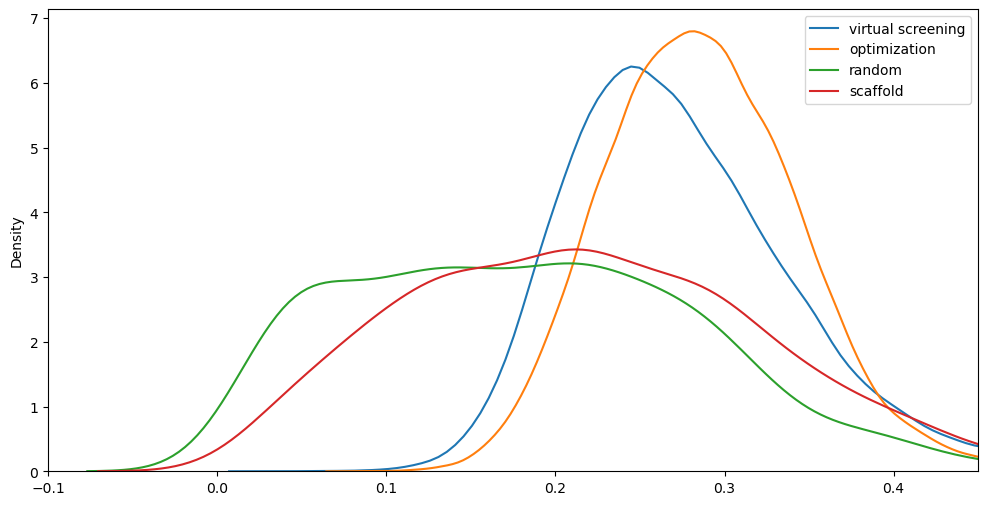

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(vs_dist, ax=ax, label="virtual screening")
sns.kdeplot(op_dist,ax=ax, label="optimization")

for seed in range(1):
    X_train, X_test, _, _ = train_test_split(X, y, test_size=0.2, random_state=seed)
    distances = compute_knn_distance(X_train, X_test)
    sns.kdeplot(distances, ax=ax, label="random")

    scaffold = np.array([dm.to_smiles(dm.to_scaffold_murcko(dm.to_mol(smi))) for smi in smiles])
    splitter = PredefinedGroupShuffleSplit(scaffold, random_state=0)
    train, test = next(splitter.split(X))
    X_train, X_test = X[train], X[test]
    distances = compute_knn_distance(X_train, X_test)
    sns.kdeplot(distances, ax=ax, label="scaffold")
    
ax.set_xlim(-0.1, 0.45)
ax.legend()